<a href="https://colab.research.google.com/github/nooraovo/nooraovo.github.io/blob/main/Multi_neuron_exp1_sample_data_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import copy
import random

In [2]:
class TwoLayerNN(nn.Module):
  def __init__(self, m, d): # fix the second layer to be all 1
    super().__init__()
    self.fc1 = nn.Linear(d, m, bias=False)
    self.fc2 = nn.Linear(m, 1, bias=False)

  def activation(self, x): # cubic relu activation
    return (x.clamp(min=0))

  def forward(self, x):
    _output = self.activation(self.fc1(x))
    output = self.fc2(_output)
    return output

  def init_gaussian(self, init_scales):
    self.fc1.weight.data = init_scales[0] * torch.randn_like(self.fc1.weight)
    self.fc2.weight.data = init_scales[1] * torch.randn_like(self.fc2.weight)

  def features(self, x, normalize=True, scaled=False, n_hidden_to_take=-1):
    x = F.relu(self.fc1(x))
    if scaled and n_hidden_to_take in [-1, 3]:
      x = self.fc2(x)
    if normalize:
      x /= (x**2).sum(1, keepdim=True)**0.5
      x[torch.isnan(x)] = 0.0
    return x.data.numpy()

  def feature_sparsity(self, X, n_hidden_to_take=-1, corr_threshold=0.99):
    phi = self.features(X, n_hidden_to_take=n_hidden_to_take)
    idx_keep = np.where((phi > 0.0).sum(0) > 0)[0]
    phi_filtered = phi[:, idx_keep]  # filter out zeros
    corr_matrix = np.corrcoef(phi_filtered.T)
    corr_matrix -= np.eye(corr_matrix.shape[0])

    idx_to_delete, i, j = [], 0, 0
    while i != corr_matrix.shape[0]:
      # print(i, corr_matrix.shape, (np.abs(corr_matrix[i]) > corr_threshold).sum())
      if (np.abs(corr_matrix[i]) > corr_threshold).sum() > 0:
        corr_matrix = np.delete(corr_matrix, (i), axis=0)
        corr_matrix = np.delete(corr_matrix, (i), axis=1)
        # print('delete', j)
        idx_to_delete.append(j)
      else:
        i += 1
      j += 1
    assert corr_matrix.shape[0] == corr_matrix.shape[1]
    # print(idx_to_delete, idx_keep)
    idx_keep = np.delete(idx_keep, [idx_to_delete])
    sparsity = (phi[:, idx_keep] != 0).sum() / (phi.shape[0] * phi.shape[1])

    return sparsity

In [114]:
n_train = 15
n_test = 1000
D_in = 2
D_out = 1
m = 20
m_teacher = 3
l0_threshold_grad_matrix = 0.001
init_scales_teacher= [1.0, 1.0]
seed = 0

def get_data(n, D_in):
  x=torch.randn(n,D_in)
  torch.nn.init.normal_(x, 0, 1) # initialize x

  u=torch.rand(D_in,D_out)
  u=u/u.norm() # ||u||=1
  y=x.mm(u)
  y=y.clamp(min=0)

  return x, y

def get_data_two_layer_relu_net(n, d, m_teacher, init_scales_teacher, seed):
    seed = random.randint(1, 100)
    np.random.seed(seed)
    torch.manual_seed(seed)

    n_test = 1000
    H = np.eye(d)
    X = torch.tensor(np.random.multivariate_normal(np.zeros(d), H, n)).float()
    X = X / torch.sum(X**2, 1, keepdim=True)**0.5
    X_test = torch.tensor(np.random.multivariate_normal(np.zeros(d), H, n_test)).float()
    X_test = X_test / torch.sum(X_test**2, 1, keepdim=True)**0.5

    # generate ground truth labels
    with torch.no_grad():
        net_teacher = TwoLayerNN(m_teacher, d)
        # net_teacher.apply(weights_init)
        net_teacher.init_gaussian(init_scales_teacher)
        net_teacher.fc1.weight.data = net_teacher.fc1.weight.data / torch.sum((net_teacher.fc1.weight.data)**2, 1, keepdim=True)**0.5
        net_teacher.fc2.weight.data = torch.sign(net_teacher.fc2.weight.data)

        y, y_test = net_teacher(X), net_teacher(X_test)

        print('y', y[:20, 0])

    return X, y, X_test, y_test, net_teacher

In [122]:
x, y, x_test, y_test, net_teacher = get_data_two_layer_relu_net(n_train, D_in, m_teacher, init_scales_teacher, seed)
model =  TwoLayerNN(m, D_in)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=.9, weight_decay=0)
criteria = nn.MSELoss()

y tensor([ 0.3191,  0.8679,  0.9995,  0.9791, -0.9995, -0.4269,  0.9871,  0.9537,
         0.1409,  0.9744, -0.4736,  0.6153,  0.9939,  0.8753, -0.7613])


In [116]:
def weights_init(m):
  for p in m.parameters():
    nn.init.xavier_uniform_(p, gain=.1)

def train(epochs, lr, model):
  train_loss, nets_avg, norm = [], [], []
  # model = TwoLayerNN(m, D_in)
  # model.apply(weights_init)
  # model.init_gaussian(init_scales = [0.5, 0.0])
  net, net_avg = copy.deepcopy(model), copy.deepcopy(model)
  optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0, weight_decay=0)
  net.train()

  for epoch in range(epochs):
    tmp = []
    output = net(x)
    loss = criteria(output, y)
    if epoch % 100 == 0:
      print (epoch, loss.item())
      nets_avg.append(copy.deepcopy(net))
    train_loss += [loss.item()]


    for p in net.parameters():
      tmp += [(p.clone().detach()**2).sum(dim=-1).numpy()]
      break;
    norm += [tmp]

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

  return train_loss, nets_avg, norm

In [6]:
def compute_grad_matrix(net, X):
    optimizer = torch.optim.SGD(net.parameters(), lr=0.0)
    grad_matrix_list = []
    for i in range(X.shape[0]):
        h = net(X[[i]])
        optimizer.zero_grad()
        h.backward()

        grad_total_list = []
        for param in net.parameters():
            grad_total_list.append(param.grad.flatten().data.numpy())

        grad_total = np.concatenate(grad_total_list)
        grad_matrix_list.append(grad_total)

    grad_matrix = np.vstack(grad_matrix_list)
    return grad_matrix

def compute_grad_matrix_ranks(nets, X, l0_threshold_grad_matrix=0.0001):
    n_params = sum([np.prod(param.shape) for param in nets[-1].parameters()])
    X_eval = X[:n_params]
    grad_matrix_ranks = []
    for net in nets:
        svals = np.linalg.svd(compute_grad_matrix(net, X_eval))[1]
        rank = (svals / svals[0] > l0_threshold_grad_matrix).sum()
        grad_matrix_ranks.append(rank)
    return grad_matrix_ranks

def compute_w_ranks(nets, threshold):
  w_ranks = []
  for net in nets:
    for p in net.parameters():
      svals = np.linalg.svd(p.data.numpy())[1]
      rank = (svals / svals[0] > threshold).sum()
      w_ranks.append(rank)
      break;
  return w_ranks

In [123]:
model = TwoLayerNN(m, D_in)
model.apply(weights_init)
#model.init_gaussian(init_scales = [0.5, 0.0])

TwoLayerNN(
  (fc1): Linear(in_features=2, out_features=20, bias=False)
  (fc2): Linear(in_features=20, out_features=1, bias=False)
)

In [124]:
lr_small = 0.002
loss_small, net_small, norm_small = train(100000, lr=lr_small, model = model)

0 0.6512941122055054
100 0.6490861773490906
200 0.6467450857162476
300 0.6442161202430725
400 0.6413271427154541
500 0.637984573841095
600 0.634030282497406
700 0.6292782425880432
800 0.6236122250556946
900 0.6167903542518616
1000 0.6085349917411804
1100 0.5986340045928955
1200 0.5867627263069153
1300 0.572592556476593
1400 0.555949330329895
1500 0.5366604328155518
1600 0.5145988464355469
1700 0.48999249935150146
1800 0.46319499611854553
1900 0.43476346135139465
2000 0.4054829478263855
2100 0.3762677311897278
2200 0.34783563017845154
2300 0.3207060396671295
2400 0.2952522039413452
2500 0.2716212272644043
2600 0.2497636377811432
2700 0.2295408546924591
2800 0.21082089841365814
2900 0.1934935450553894
3000 0.17737029492855072
3100 0.16236425936222076
3200 0.1484171450138092
3300 0.1353324055671692
3400 0.12321753054857254
3500 0.11207351833581924
3600 0.10185220092535019
3700 0.09246782958507538
3800 0.08383157849311829
3900 0.0759614035487175
4000 0.06880117952823639
4100 0.062297303229

In [125]:
lr_large = 0.2
loss_large, net_large, norm_large = train(100000, lr=lr_large, model = model)

0 0.6512941122055054
100 0.0028611088637262583
200 0.0012055464321747422
300 0.0009845765307545662
400 0.0009182295179925859
500 0.0008827888523228467
600 0.000856903730891645
700 0.0008342328947037458
800 0.0008118972182273865
900 0.0007896159659139812
1000 0.000767131510656327
1100 0.0007443490903824568
1200 0.0007208575843833387
1300 0.0006974653224460781
1400 0.0006735247443430126
1500 0.0006495221168734133
1600 0.0006255499902181327
1700 0.0006013456149958074
1800 0.0005771665601059794
1900 0.0005532209179364145
2000 0.0005297816242091358
2100 0.0005062826094217598
2200 0.00048349544522352517
2300 0.00046118785394355655
2400 0.00043944010394625366
2500 0.0004183277487754822
2600 0.00039792826282791793
2700 0.0003780965053010732
2800 0.0003592490393202752
2900 0.00034108065301552415
3000 0.0003237614582758397
3100 0.0003072625841014087
3200 0.0002915104560088366
3300 0.0002766135148704052
3400 0.0002624826447572559
3500 0.0002491067280061543
3600 0.00023641291772946715
3700 0.00022

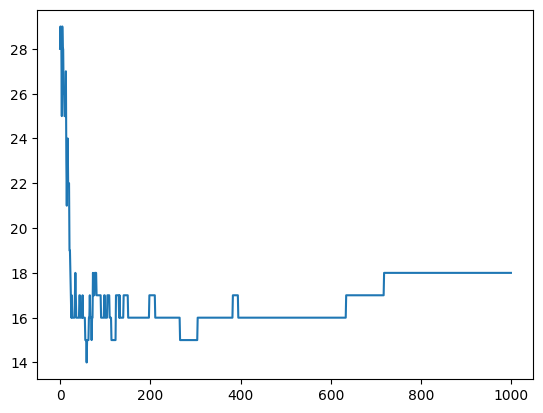

In [126]:
n_params = sum([np.prod(param.shape) for param in net_small[-1].parameters()])
grad_matrix_ranks_small = compute_grad_matrix_ranks(net_small, x_test[:n_params], l0_threshold_grad_matrix)
plt.plot(grad_matrix_ranks_small)

TwoLayerNN(
  (fc1): Linear(in_features=2, out_features=20, bias=False)
  (fc2): Linear(in_features=20, out_features=1, bias=False)
)


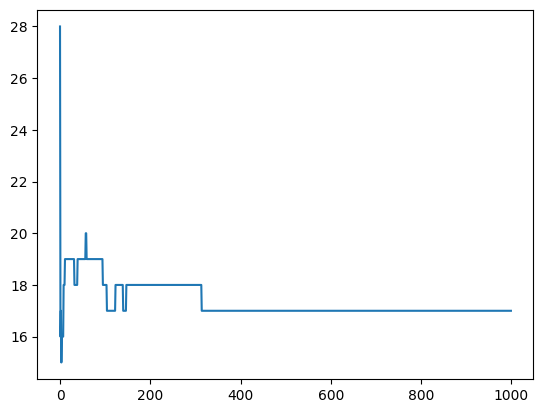

In [127]:
print(net_large[1])
n_params = sum([np.prod(param.shape) for param in net_large[-1].parameters()])
grad_matrix_ranks_large = compute_grad_matrix_ranks(net_large, x_test[:n_params], l0_threshold_grad_matrix)
plt.plot(grad_matrix_ranks_large)

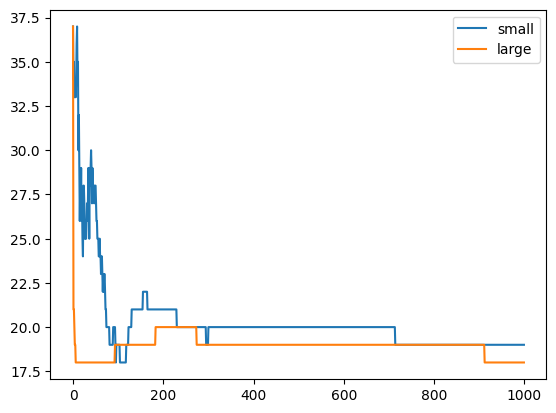

In [107]:
fig,ax = plt.subplots()
plt.plot(grad_matrix_ranks_small, label='small')
plt.plot(grad_matrix_ranks_large, label='large')
ax.legend()

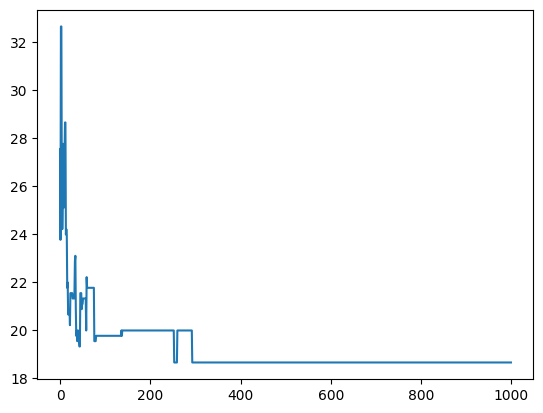

In [108]:
feature_sparsity_small = np.array([net.feature_sparsity(x) for net in net_small])
plt.plot(100*feature_sparsity_small)

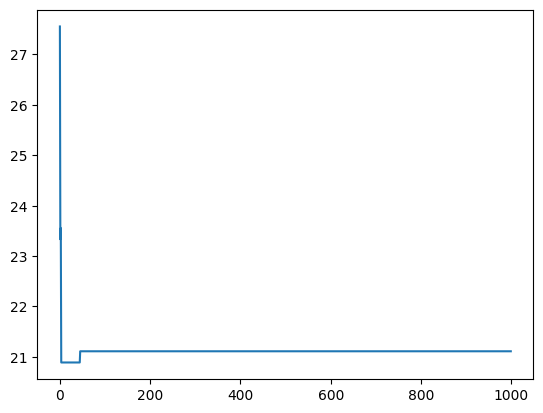

In [109]:
feature_sparsity_large = np.array([net.feature_sparsity(x) for net in net_large])
plt.plot(100*feature_sparsity_large)

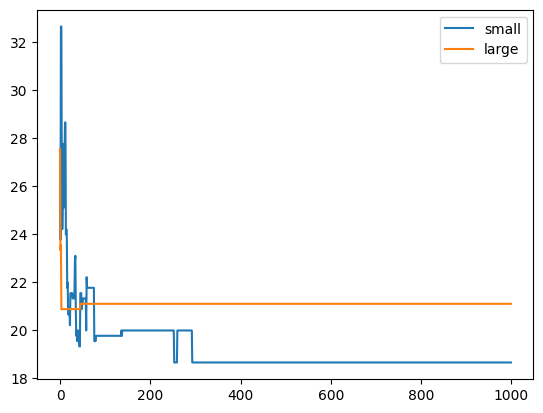

In [110]:
fig,ax = plt.subplots()
plt.plot(100*feature_sparsity_small, label='small')
plt.plot(100*feature_sparsity_large, label='large')
ax.legend()

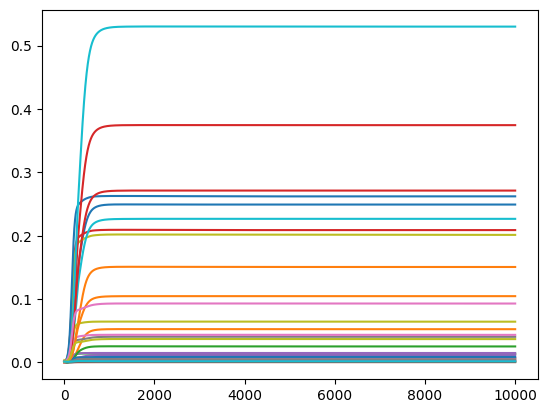

In [111]:
norm_small = np.array(norm_small)
for i in range(m):
  plt.plot(norm_small[::10, 0, i])

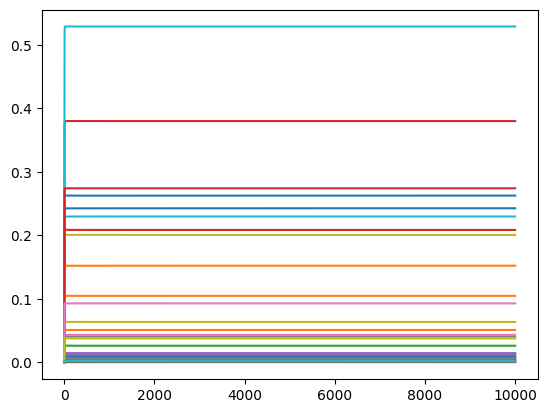

In [112]:
norm_large = np.array(norm_large)
for i in range(m):
  plt.plot(norm_large[::10, 0, i])

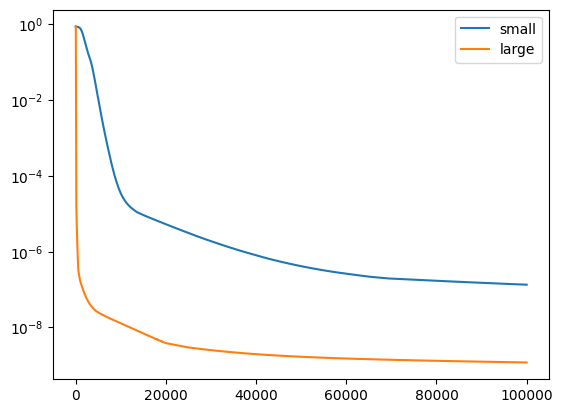

In [113]:
fig,ax = plt.subplots()
plt.yscale('log')
plt.plot(loss_small, label='small')
plt.plot(loss_large, label='large')
ax.legend()